# PCA with PyKrev

* 1.1: In the first part of the guide we will cover how to perform PCA on your FT-MS data using the sklearn (sci-kit learn) library and PyKrev.  PCA is a dimensionality reduction technique which projects your data onto a smaller subset of axis (known as principal components) whilst preserving maximum variance.
In this guide we will cover: 
 * Data Preparation 
 * Scree and variance plots
 * 2D PCA plots
 * Loading plots

*One thing to note: PCA is not always the most appropriate technique for performing multivariate analysis on complex mixture FT-MS data. PCA is based on eigendecomposition of the covariance matrix of our dataset, but the covariance matrix may not be the most appropriate measure of association. Two features of FT-MS datasets can cause issues with PCA. The first is a large number of shared zeros (i.e. samples that do not contain a particular formula share 0 peak intensities for that formula in the ordination matrix). In the PCA routine this can lead to false positive  relationships, as samples that share many zero values will appear more similar to one another. The second is that PCA is designed for normally distributed variables (i.e. the peak intensities across all samples for a given molecular formula should be normally distributed). This is often not the case in FT-MS datasets. An alternative multivariate analysis technique called principal coordinate analysis (PCoA) can be used which is more robust to these issues. This will be the topic of a later guide.*

In [1]:
from sklearn.decomposition import PCA #if you do not already have the library installed run 'pip install scikit-learn'
import pykrev as pk
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd

In [2]:
np.random.seed(87) ## seed the RNG (for reproducible figures)

* 1.2: First we need to load in our dataset. In this example we are going to load in a batch aligned dataset. ```read_batch_formularity``` can then compute an ordination matrix directly on the data.
  * The dataset was taken from [Kew, Will, et al. (2018)](https://pubs.acs.org/doi/10.1021/acs.analchem.8b01446) and consists of four whisky samples (W1 - W4) analysed using four complementary ionisation techniques (ESI, LDI, APCI, APPI) through FT-ICR-MS with formula assignment rules of O>0, N<2, S<=2, P<1.

In [3]:
fdata, fordination = pk.read_batch_formularity('../example_data/mixed_batch.csv', impute_value = 0)
nsample, nformula = fordination.shape #the ordination matrix has samples in rows and formula in columns

In [4]:
fordination.head()

,C43H38O13,C18H26O10,C17H8O9,C33H24O9,C23H20O6,C22H28O6,C16H20O10S1,C5H10O4,C20H10O8,C22H32O15,...,C11H16O8,C21H16O5S1,C20H20O5,C32H36O14,C33H20O9,C21H28O12,C21H16O6,C24H24O15,C13H18O14S1,C31H36O14
ESI-1,0,0,0,0,0,0,3310489,0,0,0,...,5756230,3236851,0,0,0,0,0,4564987,8659251,0
ESI-2,0,2836379,0,0,0,0,0,0,0,0,...,12636752,0,0,0,0,3362916,0,0,0,0
ESI-3,0,3956754,0,0,0,0,0,2526711,0,0,...,16432499,0,0,0,0,3765280,0,0,0,0
ESI-4,0,2863474,0,0,0,0,0,0,0,0,...,13017196,0,0,0,0,3637662,0,0,0,0
LDI-1,0,0,36219212,5518497,12413556,0,0,0,20883324,0,...,0,0,9108067,4298913,3720748,0,16848004,0,0,0


* 1.3: We should normalise the intensity across rows to aid comparison between spectra aquired in different samples. Normalisation calculations are performed on the rows of the ordination matrix using ```normalise_intensity```. 
   * In this example we will use z-score normalised intensity (also known as snv). For each spectra this sets the mean of all peak intensities to 0 and the standard deviation to 1. 
     The formula for calculating the z-score of a point, x, is as follows: $x' = (x - \mu)/\sigma$. 
    * Other normalisation options available in PyKrev include pareto, mean, median and minmax normalisation, as well as sum and unit vector relative intensity and log transformation. ```normalise_intensity``` provides the functionality to perform most of the normalisation methods used in the literature. I recommend reading [van den Berg, et al.](https://link.springer.com/article/10.1186/1471-2164-7-142) for an overview of how these methods can affect metabolomics data analysis.
  * If you would like to avoid making relative intensity calculations on your data, you can process the ordination matrix as a binary matrix, which indicates the presence or absence of a formula (1 or 0) but does not contain information about its abundance. Setting the ```norm_method``` argument to ```binary``` will create this for you. An alternative technique such as [Principal Coordinate Analysis (PCoA)](https://www.sequentix.de/gelquest/help/principal_coordinates_analysis.htm#:~:text=Principal%20Coordinates%20Analysis%20(PCoA%2C%20%3D,e.g.%20as%20a%203D%20graphics) should be used for binary data.

In [77]:
nordination = pk.normalise_intensity(fordination, norm_method = 'zscore') #this will compute zscore normalisation on rows of the dataframe
assert np.std(nordination.iloc[0,:]) == 1
assert np.mean(nordination.iloc[0,:]) < 0.001 and np.mean(nordination.iloc[0,:]) > -0.999

* 1.4: Now we are ready to perform PCA using the [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) library. PCA is performed by computing the eigenvectors of the covariance matrix of our dataset. The eigenvalues of each of these vectors explain how much of the variance was captured by their eigenvector. The PCA class within the sklearn library allows you to modify the method used to perform the eigendecomposition and change the number of components to keep. We are going to use the default parameters in which all principal components are kept.

In [19]:
pca = PCA() #instance of the PCA class, here we can define parameters about the PCA 
pca.fit(nordination) #fit the PCA intialised with default parameters to our data
pca_result = pca.transform(nordination) # transform our data with the fitted model

* 1.5: One way to visualise the variance explained by your principal coordinates is with a scree plot and a variance plot. You can use the ```scree_plot``` and ```variance_plot``` functions i've defined below to do this. 

In [20]:
def scree_plot(pca_instance, **kwargs):
    """ This function creates a scree plot on the results of the sklearn implementation of PCA."""
    varExplained = pca_instance.explained_variance_ 
    componentN  = np.arange(1,len(varExplained)+1)
    plt.bar(componentN,varExplained, **kwargs)
    plt.xticks(componentN)
    plt.xlabel('Principal Component')
    plt.ylabel('Eigenvalue')
    return plt.gcf(), plt.gca()

In [21]:
def variance_plot(pca_instance, **kwargs):
    """ This function creates a variance plot on the results of the sklearn implementation of PCA."""
    varExplained = pca_instance.explained_variance_ratio_
    cumVarExplained = np.cumsum(pca_instance.explained_variance_ratio_)
    componentN  = np.arange(1,len(varExplained)+1)
    plt.scatter(componentN,varExplained)
    plt.plot(componentN,varExplained, linestyle = '-', **kwargs)
    plt.scatter(componentN,cumVarExplained)
    plt.plot(componentN,cumVarExplained, linestyle = '--',**kwargs)
    plt.xticks(componentN)
    plt.xlabel('Principal Component')
    plt.ylabel('Variance explained ')
    plt.legend(['Proportion','Cumulative'])
    return plt.gcf(), plt.gca()   

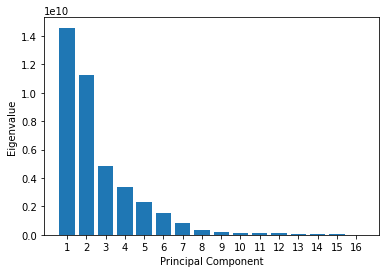

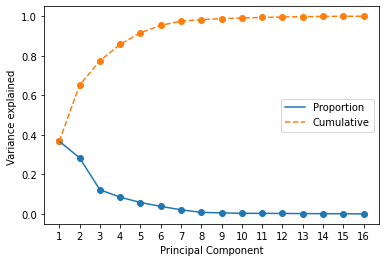

In [22]:
plt.figure()
fig, ax = scree_plot(pca)
plt.figure()
fig, ax = variance_plot(pca)

* 1.6: So the first principal component explains ~36.7% of variation in the dataset, and the second ~28.3%. Let's plot the data, to do this we will use the ```pca_plot``` function which is defined below.

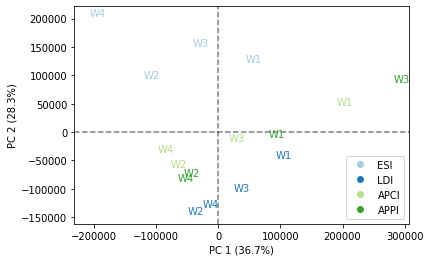

In [26]:
def pca_plot(pca_result, pca_instance, group_names, group_colours, text_offset = 0.002, text = False, **kwargs):
    """ This function creates a 2D PCA plot on the results of the sklearn implementation of PCA."""
    assert len(group_names)==len(pca_result[:,1])
    varExplained = pca_instance.explained_variance_ratio_
    for i in range(0,len(group_names)):
        # scatter points with text labels
        plt.scatter(pca_result[i,0],pca_result[i,1], s=0) #use invisible scatter points to set appropriate axis lim
        plt.text(pca_result[i,0],pca_result[i,1], s = group_names[i], c = group_colours[i])
    #label axes
    plt.xlabel(f"PC 1 ({str(varExplained[0]*100)[:4]}%)")
    plt.ylabel(f"PC 2 ({str(varExplained[1]*100)[:4]}%)")
    ## add axis lines (like abline in r)
    plt.axhline(0, color='k', linestyle = '--', alpha = 0.5)
    plt.axvline(0, color='k', linestyle = '--', alpha = 0.5)
    return plt.gcf(), plt.gca() 

sample_names = ['W1','W2','W3','W4'] * 4 
sample_colours = ['#a6cee3'] * 4 + ['#1f78b4'] * 4 + ['#b2df8a'] * 4 + ['#33a02c'] * 4 #colour blind safe! 

fig, ax = pca_plot(pca_result = pca_result, pca_instance = pca, text = True,
         group_names = sample_names, group_colours = sample_colours)

#set a custom legend 
legend_elements = [Line2D([0], [0], marker='o', color='w', label='ESI',
                      markerfacecolor='#a6cee3', markersize=8),
               Line2D([0], [0], marker='o', color='w', label='LDI',
                      markerfacecolor='#1f78b4', markersize=8),
               Line2D([0], [0], marker='o', color='w', label='APCI',
                      markerfacecolor='#b2df8a', markersize=8),
               Line2D([0], [0], marker='o', color='w', label='APPI',
                      markerfacecolor='#33a02c', markersize=8)] 
plt.legend(handles = legend_elements, loc = 'lower right')

* 1.7: The PCA plot is useful to visualise the separation between our samples, but how do the features of our dataset (in this case the molecular formula) contribute to this separation? To visualise this we will use loading plots. 
 * First we need to extract the loadings and label them by their corresponding molecular formula. 

In [54]:
formula = list(fordination.columns) #extract the column headers from the ordination matrix 
loadings = pca.components_.T #extract the loadings of the formula 
loadingDF= pd.DataFrame(loadings,formula) #this constructs a dataframe with the formula as rows and the loadings for the four principal components as columns
loadingDF.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
C43H38O13,-0.000955,-0.001073,-0.003980,-0.001216,0.000063,0.000635,-0.008046,0.000422,0.001642,-0.000641,-0.002279,0.010238,0.008719,0.000395,0.001872,0.134128
C18H26O10,-0.002539,0.000409,0.000293,-0.000914,-0.000216,-0.002342,-0.007398,0.013646,0.001691,0.017522,0.008449,-0.002535,-0.005312,-0.001652,0.022692,-0.651752
C17H8O9,0.008131,-0.004595,-0.011774,-0.018538,0.002956,0.030695,0.082869,0.009617,-0.024259,0.009918,-0.017652,-0.023441,-0.001234,0.008734,-0.003681,-0.053145
C33H24O9,-0.000366,-0.004094,-0.006981,-0.006211,0.004985,0.002257,0.001330,0.002458,-0.003020,-0.000104,-0.000264,-0.001383,-0.002667,-0.001673,-0.000618,-0.077129
C23H20O6,0.000581,-0.019575,-0.015018,-0.027779,0.032319,-0.017246,-0.002524,0.011831,0.003970,0.009112,-0.007195,0.007417,0.009202,-0.002969,-0.002960,0.171618


* 1.8: Now we have to visualise our loadings. There are many ways we can do this and it's a great place to get creative. Functions in the formula, plotting and diversity packages in PyKrev can help. Below I have defined functions to create : 

  * a loading plot that recreates a mass spectrum with the contribution of masses to the PCs using ```mass_loading_plot```.
  * a loading plot that shows the sum contribution of compound classes to the PCs using ```cclass_loading_plot```.
  * a loading plot that shows the sum contribution of oxygen classes to the PCs using ```oxygen_loading_plot```.


In [37]:
def mass_loading_plot(loadingDF):
    """This function takes a loading dataframe and plots the loadings of the first 2 PCs against mass"""
    formula = list(loadingDF.index)
    pk.mass_spectrum(formula_list=formula, peak_intensities= loadingDF.iloc[:,0],method = 'average', normalise= False, color = 'b')
    pk.mass_spectrum(formula_list=formula, peak_intensities= loadingDF.iloc[:,1],method = 'average', normalise= False, color = 'orange')
    plt.ylabel('Loading')
    plt.legend(['PC1','PC2'])
    
    return plt.gcf(), plt.gca()

In [38]:
def cclass_loading_plot(loadingDF):
    """This function takes a loading dataframe and plots a bar chart of compound class 
        with the sum loadings of the first 2 PCs """
    formula = list(loadingDF.index)
    #perform compound class assignment using the formularity assignment rules
    assignments, counts = pk.compound_class(formula,method = 'FORM')
    #make a dictionary to store the sum of the loading values per compound class inside 
    # for PC1
    compoundPC1 = dict()
    # initialise dictionary with 0 values
    for i in range(0,len(loadingDF.index)):
        compoundPC1[assignments[i]] = 0 
    # sum the assignment values 
    for i in range(0,len(loadingDF.index)):
        compoundPC1[assignments[i]] += loadingDF.iloc[i,0]
    # sort the compound classes dictionaries alphabetically (ordered dicts possible in >Python 3.7)
    sortedPC1 = dict()
    for s in sorted(compoundPC1):
        sortedPC1[s] = compoundPC1[s]
    # for PC2 
    compoundPC2 = dict()
    for i in range(0,len(loadingDF.index)):
        compoundPC2[assignments[i]] = 0 
    for i in range(0,len(loadingDF.index)):
        compoundPC2[assignments[i]] += loadingDF.iloc[i,1]
    sortedPC2 = dict()
    for s in sorted(compoundPC2):
        sortedPC2[s] = compoundPC2[s]
    # extract the values to plot on the y axis
    y1 = np.array(list(sortedPC1.values()))
    y2 = np.array(list(sortedPC2.values()))
    # create a number line for the x axis, 
    #adequately spaced to allow side by side bars for PC1 and PC2
    xrange = np.arange(0,len(y1)*3,3)
    plt.bar(xrange,y1)
    plt.bar(xrange+.8,y2)
    plt.legend(['PC1','PC2'])
    plt.axhline(0, color='k', linestyle = '--', alpha = 0.5)
    #Include xticks 
    plt.xticks(xrange,list(sortedPC1.keys()), rotation= 'vertical')
    plt.xlabel('Compound class')
    plt.ylabel('Sum loadings')
    # return the range of the x-axis (so we can set custom x ticks if needed)
    return plt.gcf(), plt.gca(), xrange

In [39]:
def oxygen_loading_plot(loadingDF):
    """This function takes a loading dataframe and plots a bar chart of oxygen class 
        with the sum loadings of the first 2 PCs """
    formula = list(loadingDF.index)
    #perform oxygen class assignment using element counts 
    oxygen_counts = [o['O'] for o in pk.element_counts(formula)]
    #make a dictionary to store the sum of the loading values per compound class inside 
    # for PC1
    oxygenPC1 = dict()
    # initialise dictionary with 0 values
    for i in range(0,len(loadingDF.index)):
        oxygenPC1[oxygen_counts[i]] = 0 
    # sum the assignment values 
    for i in range(0,len(loadingDF.index)):
        oxygenPC1[oxygen_counts[i]] += loadingDF.iloc[i,0]
    # sort the oxygen class dictionaries numerically (ordered dicts possible in >Python 3.7)
    sortedPC1 = dict()
    for s in sorted(oxygenPC1):
        sortedPC1[s] = oxygenPC1[s]
    # for PC2 
    oxygenPC2 = dict()
    for i in range(0,len(loadingDF.index)):
        oxygenPC2[oxygen_counts[i]] = 0 
    for i in range(0,len(loadingDF.index)):
        oxygenPC2[oxygen_counts[i]] += loadingDF.iloc[i,1]
    sortedPC2 = dict()
    for s in sorted(oxygenPC2):
        sortedPC2[s] = oxygenPC2[s]
    # extract the values to plot on the y axis
    y1 = np.array(list(sortedPC1.values()))
    y2 = np.array(list(sortedPC2.values()))
    # create a number line for the x axis, 
    #adequately spaced to allow side by side bars for PC1 and PC2
    xrange = np.arange(0,len(y1)*3,3)
    plt.bar(xrange,y1)
    plt.bar(xrange+.8,y2)
    plt.legend(['PC1','PC2'])
    plt.axhline(0, color='k', linestyle = '--', alpha = 0.5)
    #Include xticks 
    plt.xticks(xrange,list(sortedPC1.keys()), rotation= 'vertical')
    plt.xlabel('Oxygen class')
    plt.ylabel('Sum loadings')
    # return the range of the x-axis (so we can set custom x ticks if needed)
    return plt.gcf(), plt.gca(), xrange

* 1.9: In each case I like to plot the positions of the samples on the first two principal components next to the loading plot to make analysing the plots easier. This is possible using ```plt.subplots``` to create panelled figures. 


In [83]:
# First we want to create random x coordinates for the PC1 and PC2 points
randomx = np.array([])
for i in range(0,16):
    ## the np.random function shudders the x coordinates of the points, which is necessary to prevent overlap
    randomx = np.append(randomx,np.random.uniform(-.1,.1, 1))
 
# The following variables will be shared by all the loading plots
varExplained = pca.explained_variance_ratio_ #variance explained in your PCA results
sample_name = ['W1','W2','W3','W4'] * 4 
whisky_type = ['ESI'] * 4 + ['LDI'] * 4 + ['APCI'] * 4 + ['APPI'] * 4
group_colours = ['#a6cee3'] * 4 + ['#1f78b4'] * 4 + ['#b2df8a'] * 4 + ['#33a02c'] * 4

legend_elements = [Line2D([0], [0], marker='o', color='w', label='ESI',
                          markerfacecolor='#a6cee3', markersize=8),
                   Line2D([0], [0], marker='o', color='w', label='LDI',
                          markerfacecolor='#1f78b4', markersize=8),
                   Line2D([0], [0], marker='o', color='w', label='APCI',
                          markerfacecolor='#b2df8a', markersize=8),
                   Line2D([0], [0], marker='o', color='w', label='APPI',
                          markerfacecolor='#33a02c', markersize=8)]

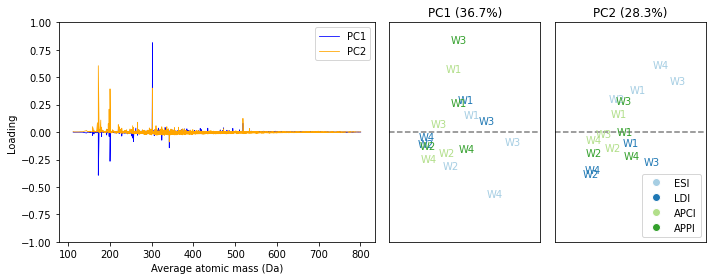

In [79]:
## MASS LOADINGS 
plt.figure(figsize=(10, 4)) # create the overall figure
plt.subplot(1,4,(1,2)) #take the first two panels of the subplot for the loading plot
mass_loading_plot(loadingDF)
plt.ylim(-1,1) # centre the y axis
plt.xlabel('Average atomic mass (Da)')
plt.subplot(1,4,3) #take the third panel for the PC1 plot
for i in range(0,16):
    plt.text(randomx[i],pca_result[i,0],s = sample_name[i],color = group_colours[i])
plt.title(f'PC1 ({str(varExplained[0]*100)[:4]}%)') #include the % variance explained in the label
plt.ylim(-.35e6,.35e6)
plt.xlim(-.15,.15)
plt.xticks([])
plt.yticks([])
plt.axhline(0, color='k', linestyle = '--', alpha = 0.5)
plt.subplot(1,4,4) #take the final panel for the PC2 plot
for i in range(0,16):
        plt.text(randomx[i],pca_result[i,1],s = sample_name[i],color = group_colours[i])
plt.title(f'PC2 ({str(varExplained[1]*100)[:4]}%)')
plt.ylim(-.35e6,.35e6)
plt.xlim(-.15,.15)
plt.xticks([])
plt.yticks([])
plt.axhline(0, color='k', linestyle = '--', alpha = 0.5)                 ]
plt.legend(handles = legend_elements, loc = 'lower right')
plt.tight_layout()
plt.show()

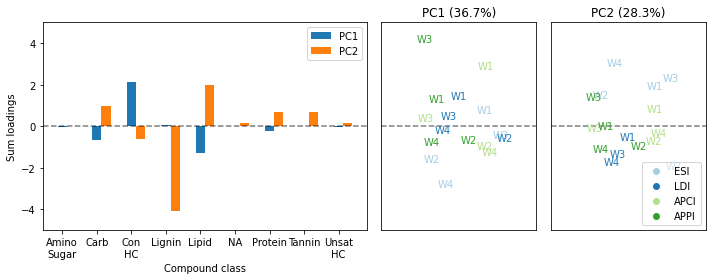

In [85]:
## COMPOUND CLASS LOADINGS 
## Important!! If you are copying this code, first check the order of your xticks before manually setting them
custom_classes = ['Amino\nSugar','Carb','Con\nHC','Lignin','Lipid','NA','Protein','Tannin','Unsat\nHC']
plt.figure(figsize=(10, 4)) # create the overall figure
plt.subplot(1,4,(1,2)) #take two panels of the subplot for the loading plot
fig, ax, xrange = cclass_loading_plot(loadingDF)
plt.ylim(-5,5) #centre the y axis
## Important!! If you are copying this code, first check the order of your xticks before manually setting them
plt.xticks(xrange,custom_classes, rotation = 'horizontal') #Set custom xticks to save space
plt.subplot(1,4,3) #take the third panel for the PC1 plot
for i in range(0,16):
    ## the np.random function shudders the x coordinates of the points, which is necessary to prevent overlap
    plt.text(randomx[i],pca_result[i,0],s = sample_name[i],color = group_colours[i])
plt.title(f'PC1 ({str(varExplained[0]*100)[:4]}%)') #include the % variance explained in the 
plt.ylim(-.35e6,.35e6)
plt.xlim(-.15,.15)
plt.xticks([])
plt.yticks([])
plt.axhline(0, color='k', linestyle = '--', alpha = 0.5)
plt.subplot(1,4,4) #take the final panel for the PC2 plot
for i in range(0,16):
        plt.text(randomx[i],pca_result[i,1],s = sample_name[i],color = group_colours[i])
plt.title(f'PC2 ({str(varExplained[1]*100)[:4]}%)')
plt.ylim(-.35e6,.35e6)
plt.xlim(-.15,.15)
plt.xticks([])
plt.yticks([])
plt.axhline(0, color='k', linestyle = '--', alpha = 0.5)             
plt.legend(handles = legend_elements, loc = 'lower right')
plt.tight_layout()
plt.show()

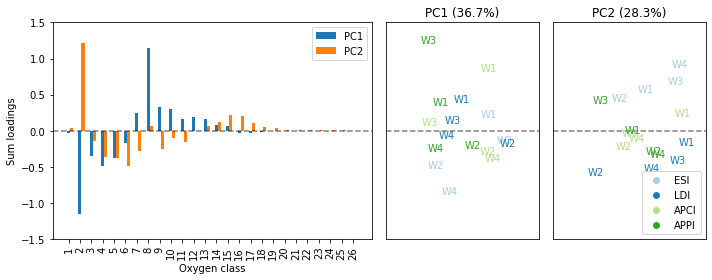

In [87]:
## OXYGEN CLASS LOADINGS 
plt.figure(figsize=(10, 4)) # create the overall figure
plt.subplot(1,4,(1,2)) #take two panels of the subplot for the loading plot
oxygen_loading_plot(loadingDF)
plt.ylim(-1.5,1.5) #centre the y axis
plt.subplot(1,4,3) #take the third panel for the PC1 plot
for i in range(0,16):
    plt.text(randomx[i],pca_result[i,0],s = sample_name[i],color = group_colours[i])
plt.title(f'PC1 ({str(varExplained[0]*100)[:4]}%)')
plt.ylim(-.35e6,.35e6)
plt.xlim(-.15,.15)
plt.xticks([])
plt.yticks([])
plt.axhline(0, color='k', linestyle = '--', alpha = 0.5)
plt.subplot(1,4,4) #take the final panel for the PC2 plot
for i in range(0,16):
        plt.text(np.random.uniform(-.1,.1, 1),pca_result[i,1],s = sample_name[i],color = group_colours[i])
plt.title(f'PC2 ({str(varExplained[1]*100)[:4]}%)')
plt.ylim(-.35e6,.35e6)
plt.xlim(-.15,.15)
plt.xticks([])
plt.yticks([])
plt.axhline(0, color='k', linestyle = '--', alpha = 0.5)              
plt.legend(handles = legend_elements, loc = 'lower right')
plt.tight_layout()
plt.show()

**That's the end of the guide.** Hopefully you are now more comfortable using sklearn and PyKrev to perform dimensionality reduction on your FT-MS data and interpret the results. One of the main advantages of doing your data analysis in Python is being able to use the powerful machine learning libraries Python has to offer. sklearn has many capabilities beyond PCA - ... discriminant analysis, k-means clustering, neural networks, random forest classifiers and  support vector machines to name just a few -  that will enable you to ask new and interesting questions with your data. [ You can learn more about them here.](https://scikit-learn.org/stable/)
  * Contact : ezra.kitson@ed.ac.uk
  * Last Updated: 22/07/2021